In [95]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from scipy.stats import iqr
import pandas as pd
import random

In [64]:
# Read in data

# data = pd.read_csv('labels_cropped.txt')
# data = pd.read_csv('labels_wavelet_nocluster.txt')
# data = pd.read_csv('labels_wavelet.txt')
# data = pd.read_csv('labels_round3_nocluster.txt')
# data = pd.read_csv('labels_round3_2feat.txt')
data = pd.read_csv('labels_round3.txt')


len(data)

217

In [65]:
data = data[data.ClusterSize>=10]


In [66]:
# Remove duplicates
data = data.drop_duplicates(subset=data.columns[1:])
# data = data.dropna()
len(data)

174

In [67]:
# X = np.array([np.log(1./data.AvgLength),data.StdAngle]).T
X = np.array([data.AvgLength,data.StdAngle]).T

# # X = np.array([data.MedLength,data.Skew]).T
# # X = data.Avglength.as_matrix().reshape(-1,1)
y = data.Label.as_matrix()

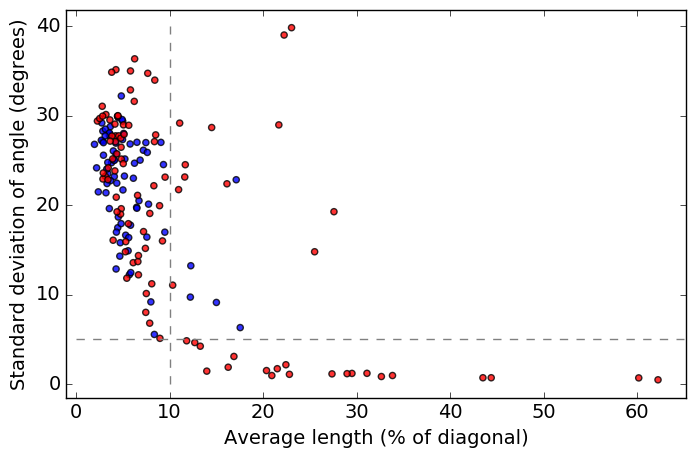

In [68]:
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 14})

colors = ['r' if label else 'b' for label in y]

sc = plt.scatter(X[:,0]*100,X[:,1],c=colors,alpha=0.8)
# plt.scatter(np.log10(1/X[:,0]),X[:,1],c=colors)
plt.xlabel('Average length (% of diagonal)')
plt.ylabel('Standard deviation of angle (degrees)')
# plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
plt.axis('tight')

plt.plot([10,10],[0,40],'--',color='gray')
plt.plot([0,65],[5,5],'--',color='gray')

plt.savefig('scatter-plot.png')

plt.show()

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [70]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))



In [103]:
Nloop = 100
acc = np.array([])
prec = np.array([])
recall = np.array([])
prec_clear = np.array([])
recall_clear = np.array([])
prec_noisy = np.array([])
recall_noisy = np.array([])

acc_best = np.array([])
acc_clear = np.array([])
acc_noisy = np.array([])
dec_reg = np.zeros(np.c_[xx.ravel(), yy.ravel()].shape[0])
for i in range(Nloop):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) #,random_state=0)

    # Logistic regression
#     clf = LogisticRegression()
#     clf.fit(X_train,y_train)

    # KNN
#     clf = KNeighborsClassifier(n_neighbors=10)
#     clf.fit(X_train,y_train)
    
#     Decision tree classification
    clf = tree.DecisionTreeClassifier(min_samples_split=2)
    clf.fit(X_train,y_train)

#     # Random Forest
#     clf = RandomForestClassifier(n_estimators=10,min_samples_split=2,random_state=0)
#     clf.fit(X_train,y_train)

    # Prediction
    y_pred = clf.predict(X)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    
    # Training and test accuracy
    train_err = float(sum(y_pred_train==y_train))/len(y_train)
    test_err = float(sum(y_pred_test==y_test))/len(y_test)
    acc = np.append(acc,test_err)
    
    ix_best = np.where((X_test[:,0]>=0.1) & (X_test[:,1]<=5))
    ix_clear = np.where(X_test[:,0]>=0.1)
    ix_noisy = np.where(X_test[:,0]<0.1)
    
    acc_best = np.append(acc_best,float(sum(y_pred_test[ix_best]==y_test[ix_best]))/len(y_test[ix_best]))
    acc_clear = np.append(acc_clear,float(sum(y_pred_test[ix_clear]==y_test[ix_clear]))/len(y_test[ix_clear]))
    acc_noisy = np.append(acc_noisy,float(sum(y_pred_test[ix_noisy]==y_test[ix_noisy]))/len(y_test[ix_noisy]))
    
#     fpr, tpr, thresholds = roc_curve(y_test, proba)
    
    # Precision and recall
    P = np.where(y_test==1)[0]
    N = np.where(y_test==0)[0]
    
    P_clear = np.intersect1d(P,ix_clear)
    N_clear = np.intersect1d(N,ix_clear)
    P_noisy = np.intersect1d(P,ix_noisy)
    N_noisy = np.intersect1d(N,ix_noisy)
    
    P_pred = np.where(y_pred_test==1)[0]
    N_pred = np.where(y_pred_test==0)[0]
    
    P_pred_clear = np.intersect1d(P_pred,ix_clear)
    N_pred_clear = np.intersect1d(N_pred,ix_clear)
    P_pred_noisy = np.intersect1d(P_pred,ix_noisy)
    N_pred_noisy = np.intersect1d(N_pred,ix_noisy)

    TP = float(len(np.intersect1d(P,P_pred)))
    TN = float(len(np.intersect1d(N,N_pred)))
    FP = float(len(np.intersect1d(N,P_pred)))
    FN = float(len(np.intersect1d(P,N_pred)))
    
    TP_clear = float(len(np.intersect1d(P_clear,P_pred_clear)))
    TN_clear = float(len(np.intersect1d(N_clear,N_pred_clear)))
    FP_clear = float(len(np.intersect1d(N_clear,P_pred_clear)))
    FN_clear = float(len(np.intersect1d(P_clear,N_pred_clear)))

    TP_noisy = float(len(np.intersect1d(P_noisy,P_pred_noisy)))
    TN_noisy = float(len(np.intersect1d(N_noisy,N_pred_noisy)))
    FP_noisy = float(len(np.intersect1d(N_noisy,P_pred_noisy)))
    FN_noisy = float(len(np.intersect1d(P_noisy,N_pred_noisy)))
    
    
#     TP_clear = float(len(np.intersect1d(P_clear,P_pred_clear)))

    Prec = TP/(TP+FP)     # high precision relates to a low false positive rate
    Recall = TP/(TP+FN)   # high recall relates to a low false negative rate

    Prec_clear = TP_clear/(TP_clear+FP_clear)
    Recall_clear = TP_clear/(TP_clear+FN_clear)

    Prec_noisy = TP_noisy/(TP_noisy+FP_noisy)
    Recall_noisy = TP_noisy/(TP_noisy+FN_noisy)
    
    prec = np.append(prec,Prec)
    recall = np.append(recall,Recall)

    prec_clear = np.append(prec_clear,Prec_clear)
    recall_clear = np.append(recall_clear,Recall_clear)
    prec_noisy = np.append(prec_noisy,Prec_noisy)
    recall_noisy = np.append(recall_noisy,Recall_noisy)

    Fscore = 2*prec*recall/(prec + recall)
    Fscore_clear = 2*prec_clear*recall_clear/(prec_clear + recall_clear)
#     acc_PN = (TP + TN)/(TP + TN + FP + FN)
#     acc2 = np.append(acc2,acc_PN)
    
#     prec_clear = np.append(prec_clear, TP/(TP+FP))

    
    # Decision regions
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    dec_reg = dec_reg + Z

dec_reg = dec_reg.reshape(xx.shape)/Nloop

ix_clear_all = np.where(X[:,0]>=0.1)
pct_clear = float(len(ix_clear_all[0]))/len(X)
# pct_clear = float(len(ix_clear_all[0]))/len(y[y==1])

ix_best_all = np.where((X[:,0]>=0.1) & (X[:,1]<=5))
pct_best = float(len(ix_best_all[0]))/len(X)
# pct_best = float(len(ix_best_all[0]))/len(y[y==1])

print np.mean(acc), np.percentile(acc,5), np.percentile(acc,95)
print np.mean(acc_clear), np.percentile(acc_clear,5), np.percentile(acc_clear,95), pct_clear
print np.mean(acc_best), np.percentile(acc_best,5), np.percentile(acc_best,95),  pct_best
print np.mean(acc_noisy)
print np.mean(prec), np.mean(recall)
print np.mean(prec_clear), np.mean(recall_clear)
print np.mean(prec_noisy), np.mean(recall_noisy)

0.612075471698 0.509433962264 0.699056603774
0.819055567798 0.635795454545 1.0 0.218390804598
0.986079004329 0.888194444444 1.0 0.120689655172
0.555225463017
0.650623428249 0.661965654502
0.904681651682 0.894092227217
0.531666221637 0.547588400041


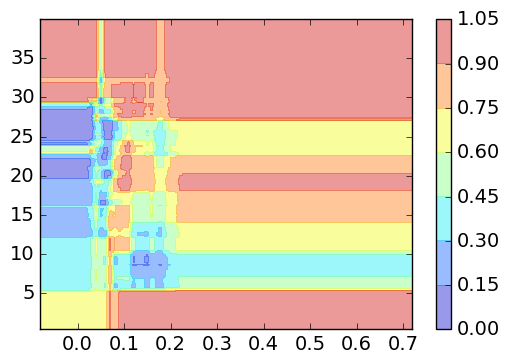

In [104]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plt.figure(figsize=(20,10))
plt.contourf(xx, yy, dec_reg, alpha=0.4)
# plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.colorbar()
plt.show()

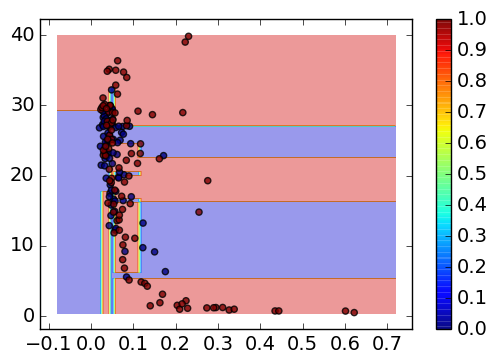

In [105]:
# Plot region with p > 0.5

Z_pos = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# ix_pos = np.where(Z_pos>0.5)[0]
Z_pos[Z_pos>0.5] = 1
Z_pos = Z_pos.reshape(xx.shape)

plt.contourf(xx, yy, Z_pos, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.colorbar()
plt.show()